In [26]:
import chipwhisperer as cw

# Initailizing the scope and target Parameters

In [27]:
scope = cw.scope()

In [28]:
target_type = cw.targets.SimpleSerial

In [29]:
target = cw.target(scope, target_type)

In [30]:
prog = cw.programmers.STM32FProgrammer

In [ ]:
import time
time.sleep(0.05)
scope.default_setup()
scope.io.nrst = 'low'
time.sleep(0.05)
scope.io.nrst = 'high_z'
time.sleep(0.05)

In [32]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

# Invoking the makefiles and Generate Necessary files for Dump on Target

In [33]:
%%sh 
cd "C:/Users/ankid/ChipWhisperer5_64/cw/home/portable/chipwhisperer/hardware/victims/firmware/simpleserial-aes"
make PLATFORM=CWNANO CRYPTO_TARGET=TINYAES128C

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make[1]: '.dep' is up to date.
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10-2020-q4-major) 10.2.1 20201103 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
    simpleserial-aes.c ...Done!
.
Compiling:
    .././simpleserial/simpleserial.c ...Done!
.
Compiling:
    .././hal/stm32f0_nano/stm32f0_hal_nano.c 

# Programming Target with .hex file

In [34]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "C:/Users/ankid/ChipWhisperer5_64/cw/home/portable/chipwhisperer/hardware/victims/firmware/simpleserial-aes/simpleserial-aes-CWNANO.hex")

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5971 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5971 bytes


# Writing the key and collecting the trace

In [48]:
from tqdm.notebook import trange
import numpy as np
import time

key = bytearray.fromhex('20 12 32 59 64 36 10 20 38 11 27 54 13 65 24 33')
#pt = bytearray.fromhex('00 11 22 33 44 55 66 77 88 99 aa bb cc dd ee ff')

target.simpleserial_write('k', key)
#target.simpleserial_write('p', pt)
time.sleep(0.1)  # The sleep is compulsory or else u will get time out error --->UART related issue

num_plaintexts= 3000
plaintexts = [bytearray([(i + j) % 256 for j in range(16)]) for i in range(num_plaintexts)]

trace_array = []
textin_array = []
textout_array = []

#key, text = ktp.next()

#target.set_key(key)

#N = 100
#Looping to each plaintext in the created plaintexts list
for p in pt:
    target.flush()
    scope.arm()
    
    target.simpleserial_write('p', p)   # Passing the Plain text
    
    ret = scope.capture()  # Increase timeout duration

    #ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)  # Read The cipher text

    textout_array.append(response)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(p)
    
    #key, text = ktp.next() 

In [46]:
import numpy as np

trace_array = np.array(trace_array)  # Convert list to NumPy array
print(trace_array.shape)  # Now you can access the shape


(100, 5000)


# Visualizing The Trace 

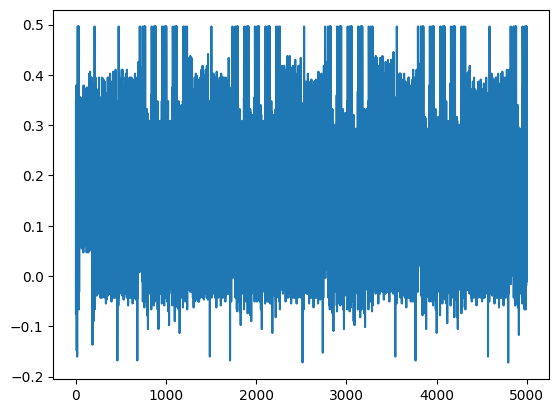

In [37]:
import matplotlib.pyplot as plt
plt.plot(trace_array[0])

In [13]:
trace_array

[array([0.28515625, 0.0234375 , 0.125     , ..., 0.30078125, 0.07421875,
        0.19921875]),
 array([0.16015625, 0.28515625, 0.03125   , ..., 0.16015625, 0.28515625,
        0.0625    ]),
 array([-0.078125  ,  0.28515625,  0.0234375 , ...,  0.1640625 ,
         0.29296875,  0.07421875]),
 array([-0.0859375 ,  0.29296875,  0.02734375, ...,  0.1640625 ,
         0.296875  ,  0.08203125]),
 array([-0.08984375,  0.2890625 ,  0.02734375, ...,  0.16015625,
         0.2890625 ,  0.0703125 ]),
 array([0.12890625, 0.28515625, 0.0234375 , ..., 0.16015625, 0.30078125,
        0.07421875]),
 array([-0.08203125,  0.296875  ,  0.03125   , ...,  0.1640625 ,
         0.29296875,  0.06640625]),
 array([0.12109375, 0.29296875, 0.03125   , ..., 0.16796875, 0.29296875,
        0.07421875]),
 array([-0.08203125,  0.296875  ,  0.03515625, ...,  0.16015625,
         0.29296875,  0.07421875]),
 array([-0.08203125,  0.296875  ,  0.03515625, ...,  0.16015625,
         0.296875  ,  0.078125  ]),
 array([-0.082

# Convert Collected data into suitable form

In [14]:
import numpy as np

trace_array = np.array(trace_array)  # Convert list to NumPy array
print(trace_array.shape)  # Now you can access the shape
textin_array=np.array(textin_array)
textout_array=np.array(textout_array)


(49, 5000)


# Saving the data in .npy file for further use

In [ ]:
np.save('trace.npy',trace_array)
np.save('plaintext.npy',textin_array)
np.save('ciphertext.npy',textout_array)

# Disconnect with scope and target

In [52]:
scope.dis()
target.dis()